In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import NaN
import seaborn as sns
sns.set()

In [4]:
food_data = pd.read_csv("2020-XTern-DS.csv")

In [5]:
food_data.head()

,Restaurant,Latitude,Longitude,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Cook_Time
0,ID_6321,39.262605,-85.837372,"Fast Food, Rolls, Burger, Salad, Wraps",$20.00,$50.00,3.5,12,4,30 minutes
1,ID_2882,39.775933,-85.740581,"Ice Cream, Desserts",$10.00,$50.00,3.5,11,4,30 minutes
2,ID_1595,39.253436,-85.123779,"Italian, Street Food, Fast Food",$15.00,$50.00,3.6,99,30,65 minutes
3,ID_5929,39.029841,-85.332050,"Mughlai, North Indian, Chinese",$25.00,$99.00,3.7,176,95,30 minutes
4,ID_6123,39.882284,-85.517407,"Cafe, Beverages",$20.00,$99.00,3.2,521,235,65 minutes


# Introduction

What do you want from a restaurant? 

That question is based heavily on personal taste. But we data scientists like to quantify just about everything that exists, and I believe that choosing a restaurant is a very quantifiable problem. 

Let's break it down into three basic qualities: **Cheap**, **Fast**, and **Good**. These three qualities are exactly what most of us are looking for in a meal, and they happen to be qualities that can be easily derived from the provided dataset.

Over the course of this notebook, we will obtain variables for the *time* it takes for your meal to get delivered, the *quality* of the meal, and the *price*. We will combine these three metrics into a composite score for each restaurant and use this metric to find Indy's best eats. Without further ado, let's begin!

## Conclusion One: Restaurant Locations


The longitude and latitudes of the restaurants are remarkably evenly distributed:


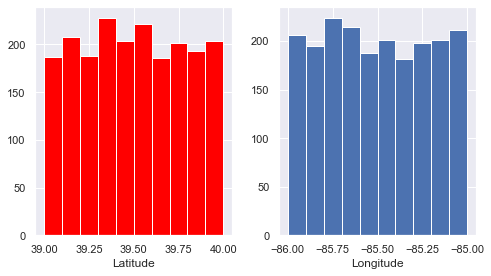

In [6]:
plt.figure(figsize=(7,4))
plt.subplot(121)
plt.xlabel("Latitude")
plt.hist(food_data["Latitude"], color = "Red")
plt.subplot(122)
plt.xlabel("Longitude")
plt.hist(food_data["Longitude"])
plt.tight_layout()

Our next step is choosing a location for the Xtern Headquarters ("HQ"). We need a homebase to deliver the food!
This even distribution of latitudes and longitudes makes our next step of choosing this location a breeze. I'll just pick the center of the the grid (39.5 latitude, -85.5 longitude). 

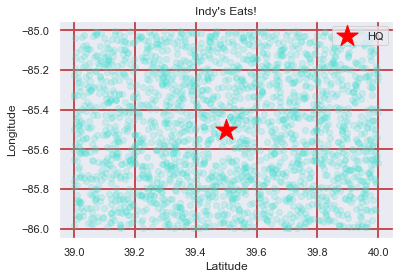

In [7]:
plt.scatter(food_data["Latitude"], food_data["Longitude"], color='turquoise', alpha=0.2)
plt.grid(color='r', linewidth=2)
plt.scatter(39.5, -85.5, marker='*', color = 'red', s=500, label = "HQ")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Indy's Eats!")
plt.legend(loc="upper right")

## Conclusion Two: Distances and Time

Our next step is to convert the raw longitude and latitude data into information that has actual meaning to us. We want to know how far away (in miles) a restaurant is from HQ based off its longitude and latitude points.

We run into a bit of a problem with the longitude/latitude measurements. I plugged in the actual longitude/latitude coordinates into Google Maps and found out that the grid pictured above is about 4000 square miles of land area. That's a bit unfeasible for food delivery!

Thus, for simplicity purposes, I'm going to "shrink" the grid to represent a 100 square mile grid instead. Anything more than a 10 mile by 10 mile grid is probably a bit too far for food delivery.  1 degree of longitude and 1 degree of latitude will both represent 10 miles (I'm not taking into account the curvature of the earth here because that's going way too deep!)

With that in mind, we can make a new column representing the (euclidean) distance of each restaurant from the "HQ" location!

In [8]:
def dist_in_miles(latitude, longitude):
    """Takes in latitude/longitude columns 
    and returns new column representing distance in miles"""
    hq_lat, hq_long = (39.5, -85.5) #location of HQ
    scaling_factor = 10 #miles per degree of longitude/latitude
    euclidean_dist = ((latitude-hq_lat)**2 + (longitude-hq_long)**2) ** 0.5 #euclidean distance formula
    return scaling_factor * euclidean_dist

food_data["Distance_from_HQ"] = dist_in_miles(food_data["Latitude"], food_data["Longitude"])

Here is a plot of the distances from HQ. We'd expect the plot to look mostly like a normal distribution and that's exactly what we get. It doesn't look completely normal because our grid of longitude/longitude points is a square, not a circle.

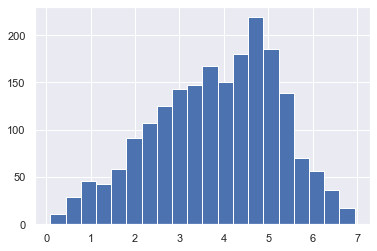

In [9]:
plt.hist(food_data["Distance_from_HQ"], bins=20);

Now that we have some useful distance data, let's calculate the the delivery time!

With a bit of online research, I discovered that the downtown Indianapolis speed limit is 25 mph:
https://www.wishtv.com/news/council-changes-downtown-speed-limit-to-25-mph-increases-parking-meter-hours/

Let's take traffic into account and bump the average speed of our delivery drivers down to 20 mph. We can now calculate how long a delivery will take! We will assume our delivery drivers are pros at timing and will arrive at the restaurant within 2 minutes of when the order is finished.

First, we have to do a bit of preprocessing and convert the Cook_Time column into a numerical format.

In [10]:
food_data["Cook_Time"].value_counts()

30 minutes     1346
45 minutes      484
65 minutes      177
120 minutes       6
20 minutes        3
10 minutes        2
80 minutes        1
Name: Cook_Time, dtype: int64

In [11]:
food_data["Cook_Time"] = [float(val.split()[0]) for val in food_data["Cook_Time"]]

In [12]:
average_speed = 20
food_data["One_Way_Drive_Time"] = (food_data["Distance_from_HQ"] / average_speed)*60 #returns drive time in minutes
food_data["Total_Time"] = food_data["Cook_Time"].astype(float) + food_data["One_Way_Drive_Time"] + 2 #the extra 2 minutes is for any excess time it might take

Text(0.5, 1.0, 'Total Time (in minutes)')

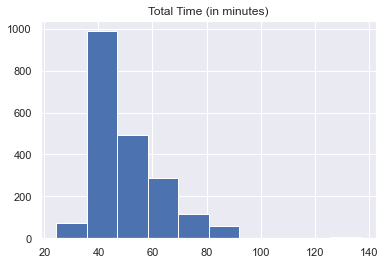

In [13]:
plt.hist(food_data["Total_Time"], bins = 10);
plt.title("Total Time (in minutes)")

As we can see above, the total time from when the order is placed to when it arrives at HQ has a median value somewhere between 40-60 minutes. Not bad!

## Conclusion Three: Quality of Restaurant

Now that we got the Time variable out of the way, let's move onto Quality!

This is where our data cleaning skills come in. As you can see, there are quite a few missing values for both Votes, Ratings, and Reviews.

In [14]:
food_data["Votes"].value_counts()

-       380
4        45
12       39
7        38
9        37
       ... 
644       1
707       1
1233      1
902       1
3535      1
Name: Votes, Length: 524, dtype: int64

In [15]:
food_data["Rating"].value_counts()

-               216
3.7             169
3.5             149
3.8             141
NEW             135
3.3             131
3.9             131
3.4             130
3.6             124
4.0             113
4.1              89
3.2              87
3.1              80
4.2              53
3.0              51
4.3              45
2.9              43
2.8              42
4.4              27
2.7              13
4.5              12
4.7              10
2.6               9
4.6               9
2.5               5
Opening Soon      2
4.8               2
2.4               1
Name: Rating, dtype: int64

We will combat this scourge by filling in these missing values with the **averages** from similar restaurants. We can define "similar" as the same cuisine! 

However, many of these restaurants have multiple cuisines listed separated by commas. I'm going to assume that the **first** cuisine listed for each restaurant is the "primary" one. I will use this assumption to make a new **Primary Cuisine** column and use that column to fill in the missing values for ratings. For votes and reviews, we will just fill in the number 1.

In [16]:
food_data["Cuisines"].value_counts()

North Indian                                                   152
North Indian, Chinese                                          120
Fast Food                                                       83
South Indian                                                    60
Chinese                                                         40
                                                              ... 
Arabian, Biryani                                                 1
Chinese, North Indian, South Indian, Fast Food, Street Food      1
Cafe, Italian, Continental                                       1
Chinese, Momos, Thai                                             1
North Indian, Mughlai, Chinese, Continental                      1
Name: Cuisines, Length: 726, dtype: int64

In [17]:
food_data["Primary_Cuisine"] = [val.split(',')[0] for val in food_data["Cuisines"]]

In [18]:
food_data.head()

,Restaurant,Latitude,Longitude,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Cook_Time,Distance_from_HQ,One_Way_Drive_Time,Total_Time,Primary_Cuisine
0,ID_6321,39.262605,-85.837372,"Fast Food, Rolls, Burger, Salad, Wraps",$20.00,$50.00,3.5,12,4,30.0,4.125244,12.375731,44.375731,Fast Food
1,ID_2882,39.775933,-85.740581,"Ice Cream, Desserts",$10.00,$50.00,3.5,11,4,30.0,3.660847,10.982541,42.982541,Ice Cream
2,ID_1595,39.253436,-85.123779,"Italian, Street Food, Fast Food",$15.00,$50.00,3.6,99,30,65.0,4.498181,13.494543,80.494543,Italian
3,ID_5929,39.029841,-85.332050,"Mughlai, North Indian, Chinese",$25.00,$99.00,3.7,176,95,30.0,4.992565,14.977694,46.977694,Mughlai
4,ID_6123,39.882284,-85.517407,"Cafe, Beverages",$20.00,$99.00,3.2,521,235,65.0,3.826799,11.480398,78.480398,Cafe


In [19]:
#preprocessing- we need to make our data numerical
food_data = food_data.replace(to_replace='-', value=0)
food_data = food_data.replace(to_replace="NEW", value=0)
food_data = food_data.replace(to_replace="Opening Soon", value = 0)
food_data[["Rating", "Votes", "Reviews"]] = food_data[["Rating", "Votes", "Reviews"]].apply(pd.to_numeric)

In [20]:
unique_cuisines = pd.unique(food_data["Primary_Cuisine"])
rating_map = dict() #used to map the primary cuisine to the median rating for restaurants of that cuisine 
for cuisine in unique_cuisines:
    median_rating = food_data[(food_data["Primary_Cuisine"] == cuisine) & (food_data["Rating"] > 0)]["Rating"].median()
    if median_rating is not NaN: #if there are ratings for other restaurants of that cuisine
        rating_map[cuisine] = median_rating
    else:
        rating_map[cuisine] = food_data[food_data["Rating"] > 0]["Rating"].median()

In [21]:
food_data["Rating"] = [rating if rating != 0 else rating_map[cuisine] for (cuisine, rating) in zip(food_data["Primary_Cuisine"], food_data["Rating"])]

In [22]:
food_data[["Votes", "Reviews"]] = food_data[["Votes", "Reviews"]].replace(to_replace=0, value=1)

Now comes the fun part: weighting each restaurant's score! We want to favor restaurants with more votes because that gives us a better picture of how good the restaurant actually is.

We will use the following weighted formula: 



Weighted_Ratings = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C


Where **v** represents the number of votes, **m** represents a threshold for the minimum number of votes, **R** represents the rating, and **C** represents the mean rating for all of the restaurants. IMDB actually uses this formula to rank movies!

Source: 
https://stats.stackexchange.com/questions/6418/rating-system-taking-account-of-number-of-votes

In [23]:
#(v ÷ (v+m)) × R + (m ÷ (v+m)) × C
v = food_data["Votes"]
m = 100 #this value is used to favorably weight restaurants with more votes 
R = food_data["Rating"]
C = food_data["Rating"].mean()

food_data["Weighted_Rating"] = (v / (v+m)) * R + (m / (v+m)) * C

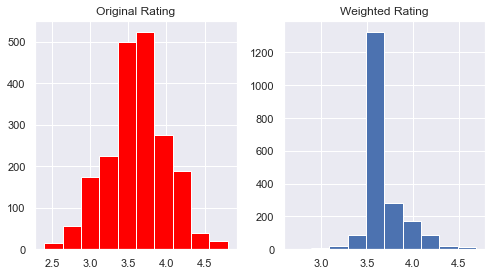

In [24]:
plt.figure(figsize=(7,4))
plt.subplot(121)
plt.title("Original Rating")
plt.hist(food_data["Rating"], color = "red")
plt.subplot(122)
plt.title("Weighted Rating")
plt.hist(food_data["Weighted_Rating"])
plt.tight_layout()

Our weighted rating formula seems to "squish" a lot more of the ratings into the 3.5-3.7 rating. I think this is desirable behavior for finding the best restaurants- the restaurants with really high ratings under this weighted scheme are much more likely to be good!

## Conclusion Four: Price and Overall Metric

We've got the Time and Quality down. Now the only step left is Price! This is relatively straightforward as the price is given. 

In [25]:
food_data.head()

,Restaurant,Latitude,Longitude,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Cook_Time,Distance_from_HQ,One_Way_Drive_Time,Total_Time,Primary_Cuisine,Weighted_Rating
0,ID_6321,39.262605,-85.837372,"Fast Food, Rolls, Burger, Salad, Wraps",$20.00,$50.00,3.5,12,4,30.0,4.125244,12.375731,44.375731,Fast Food,3.591696
1,ID_2882,39.775933,-85.740581,"Ice Cream, Desserts",$10.00,$50.00,3.5,11,4,30.0,3.660847,10.982541,42.982541,Ice Cream,3.592522
2,ID_1595,39.253436,-85.123779,"Italian, Street Food, Fast Food",$15.00,$50.00,3.6,99,30,65.0,4.498181,13.494543,80.494543,Italian,3.601356
3,ID_5929,39.029841,-85.332050,"Mughlai, North Indian, Chinese",$25.00,$99.00,3.7,176,95,30.0,4.992565,14.977694,46.977694,Mughlai,3.664746
4,ID_6123,39.882284,-85.517407,"Cafe, Beverages",$20.00,$99.00,3.2,521,235,65.0,3.826799,11.480398,78.480398,Cafe,3.264847


We have to do a bit of preprocessing to get the pricing data into numerical form:

In [26]:
food_data[["Average_Cost", "Minimum_Order"]] = [[float(avg[1:].replace(',','')), float(minimum[1:].replace(',', ''))] for (avg, minimum) in zip(food_data["Average_Cost"], food_data["Minimum_Order"])]

Now that we got our pricing data ready to go, it's time to make our **composite metric**. This will be our all in one metric for determining the quality of a restaurant based on the three most important variables that we identified: Time, Quality, and Price.

The formula is as follows:

Raw Score = (Percentile of Quality + (0.75)(Percentile of Average Cost) + (0.25)(Percentile of Minimum Order) + Percentile of Total Time)

Total Score = (100)(Percentile of Raw Score) 


What this process does is get the Quality, Pricing, and Time metrics all on the same scale. I represented the Pricing metric as (0.75)(Percentile of Average Cost) + (0.25)(Percentile of Minimum Order)- these coefficients are arbitrary and can be adjusted as you please.

In [27]:
rating_percentiles = food_data["Weighted_Rating"].rank(pct=True)
avg_cost_percentiles = food_data["Average_Cost"].rank(pct=True, ascending=False)
min_order_percentiles = food_data["Minimum_Order"].rank(pct=True, ascending=False)
total_time_percentiles = food_data["Total_Time"].rank(pct=True, ascending=False)

In [28]:
food_data["Total_Score"] = (rating_percentiles + 0.75*avg_cost_percentiles + 0.25*min_order_percentiles + total_time_percentiles).rank(pct=True) * 100

In [29]:
food_data = food_data.sort_values(by="Total_Score", ascending=False)

## Final Conclusions

And there you have it! We have our restaurants sorted by a custom metric. 

In [30]:
food_data.head(10)

,Restaurant,Latitude,Longitude,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Cook_Time,Distance_from_HQ,One_Way_Drive_Time,Total_Time,Primary_Cuisine,Weighted_Rating,Total_Score
925,ID_1350,39.384034,-85.425799,Bakery,10.0,50.0,4.6,355,260,30.0,1.376730,4.130191,36.130191,Bakery,4.380813,100.000000
1431,ID_4267,39.775161,-85.284794,"Street Food, South Indian",5.0,0.0,4.2,765,143,30.0,3.493237,10.479712,42.479712,Street Food,4.130948,99.950471
1387,ID_7867,39.687558,-85.448107,Momos,10.0,50.0,4.4,443,177,30.0,1.946046,5.838139,37.838139,Momos,4.253167,99.900941
987,ID_3317,39.446446,-85.548392,"Momos, Chinese, Burger, Fast Food",10.0,79.0,4.1,1000,205,30.0,0.721790,2.165369,34.165369,Momos,4.054791,99.851412
169,ID_7412,39.382427,-85.499864,"North Indian, Chinese, Rolls",15.0,50.0,4.8,326,234,30.0,1.175735,3.527206,35.527206,North Indian,4.518944,99.801882
145,ID_6951,39.735048,-85.635146,South Indian,5.0,50.0,4.0,109,28,30.0,2.711305,8.133915,40.133915,South Indian,3.809904,99.752353
1829,ID_4606,39.472608,-85.418186,"Fast Food, Desserts, Beverages",15.0,50.0,4.1,3535,1631,30.0,0.862781,2.588342,34.588342,Fast Food,4.086319,99.702823
666,ID_4585,39.533025,-85.234989,"Mithai, Bakery, Fast Food",10.0,50.0,4.0,389,252,30.0,2.670606,8.011818,40.011818,Mithai,3.918752,99.653294
830,ID_6567,39.200194,-85.527915,"Bakery, Fast Food, Momos",10.0,50.0,4.1,428,160,30.0,3.011023,9.033070,41.033070,Bakery,4.005814,99.603764
1540,ID_6394,39.659266,-85.545174,South Indian,10.0,50.0,3.8,203,67,30.0,1.655487,4.966461,36.966461,South Indian,3.734884,99.554235


Here is a really cool visualization of the 10 Best Restaurants according to the Total_Score metric:

Text(0.5, 1.0, "Indy's Best Eats!")

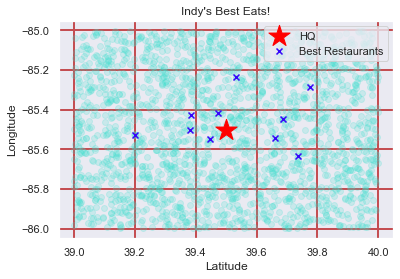

In [31]:
plt.scatter(food_data["Latitude"], food_data["Longitude"], color='turquoise', alpha=0.2)
plt.grid(color='r', linewidth=2)
plt.scatter(39.5, -85.5, marker='*', color = 'red', s=500, label = "HQ")
plt.scatter(food_data.head(10)["Latitude"], food_data.head(10)["Longitude"], marker = 'x', color = "#3705fa", label = "Best Restaurants")
plt.legend()
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Indy's Best Eats!")

From what we can see in the Latitude-Longitude plot, the "Best" restaurants tend to be closer than average to HQ (as we want them to be!). A quick visualization of the distribution of distances confirms this theory:

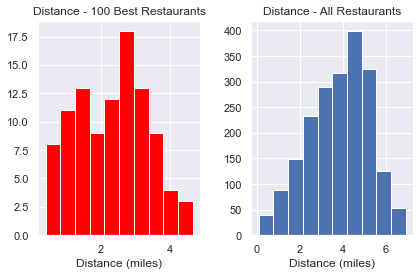

In [32]:
plt.figure()
plt.subplot(121)
plt.title("Distance - 100 Best Restaurants")
plt.xlabel("Distance (miles)")
plt.hist(food_data.head(100)["Distance_from_HQ"], color="Red")
plt.subplot(122)
plt.title("Distance - All Restaurants")
plt.xlabel("Distance (miles)")
plt.hist(food_data["Distance_from_HQ"])
plt.tight_layout()

## Assumptions and simplifications:

-We are using euclidean distance for the distances from HQ numbers. This could have a noticeable impact on driving times because you can't exactly drive through buildings to reach your destination - that's why we have roads! Thus, the actual driving times are usually going to be higher.

-The cuisines are assumed to be listed in order of importance from most important to least. If this is not actually the case, this could have a slight impact on the values that are filled in for the restaurants with missing ratings.

-We are not taking delivery charges into account here (in the interest of time) but that could make the model more robust!

And that's all folks! This project was an absolute blast and I learned a lot while completing it.

# References

https://stackoverflow.com/questions/15891038/change-column-type-in-pandas